In this notebook, I'm using transfer learning with the VGG16 and ResNet50 networks to compare their performance to the CNN I built and trained on the PCam dataset. The advantage of using transfer learning is that we can take extremely deep CNN architectures which have been pretrained on image data, and leverage their predictive power without investing the time and computing power necessary to train the networks ourselves. By "freezing" the pretrained layers and adding a small number of trainable fully connected layers onto the output of the network, we can adapt these networks to make predictions on arbitrary image data by training only a small fraction of the total available parameters.

## 1. Setting up the Notebook

In [1]:
# Import basic data science packages
import numpy as np

# Import tensorflow packages
import tensorflow as tf
from tensorflow.test import gpu_device_name

# Import various keras tools
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### 1.1 Local Setup 
> When using Google Colab, skip this cell because the import of this library is handled in the section 1.2.

In [2]:
# pcamlib.py is my library of helper functions
import pcamlib

---

### 1.2 Google Colab Setup 
> When running locally, skip these cells and continue to section 1.3.

It's a good idea when using Colab to make sure you're connected to a GPU before continuing any further.

In [3]:
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

Next, I need to mount Google Drive to access any files stored there from within Colab. This step will require following the link that appears in the cell to log into your Google account and paste the activation code in the indicated space to grant authorization to this notebook.

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

This is the path to the folder where I've cloned my GitHub repo for this project.

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone"

In [ ]:
# Navigate to the appropriate directory
%cd "{PROJECT_PATH}"

# Print the working directory to confirm the previous command worked correctly.
%pwd

I've written a library of helper functions called `pcamlib.py` which needs to be imported into Colab by running the following cell.

In [ ]:
#import pcamlib to Google Colab
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

---

### 1.3 Loading the PCam Dataset

The `.load_pcam()` function imports the Patch Camelyon dataset using `tfds.load("patch_camelyon", with_info=True)` under the hood and prints the dataset info upon completion. When using Google Colab, or if the dataset has not been previously downloaded, this cell will download the dataset from the TensorFlow database automatically, which is about 7.48 GB in size. In Colab, this cell takes between 15-20 minutes to download and prep the dataset. In order to save time when running locally, the dataset can be downloaded ahead of time by using the TFDS CLI command `tfds build patch_camelyon`. By default, the PCam dataset will be installed in `~/tensorflow_datasets/patch_camelyon/2.0.0`, but if you specified a different installation directory, you will need to set the `data_dir` parameter to the installation path.

In [3]:
pcam, pcam_info = pcamlib.load_pcam()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jaredlauer/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable

Because TensorFlow's `ImageDataGenerator()` object is difficult to configure with one of their pre-built datasets, I am utilizing code found [here](https://geertlitjens.nl/post/getting-started-with-camelyon/) to build data pipelines using `.map()`. The default batch size is 64 for the training set, and 128 for the test and validation sets.

In [8]:
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

---

## 2.0 Training the Model - VGG16

> If you are not training this model and are loading it from a file, skip ahead to section 2.2 Loading the Model - VGG16

First, we create an instance of the VGG16 network with the pretrained weights from the ImageNet dataset. It's important to set `include_top=False` so that we can strip off the Dense layers which are configured for a specified image size. `input_shape` in this case is configured to accommodate the 96x96 px, 3-channel RGB images in the PCam dataset.

In [22]:
vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(96,96,3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

Next, we freeze the pre-trained layers so that they aren't changed during the training process.

In [23]:
# Freeze all the layers in the base model
for layer in vgg16.layers:
    layer.trainable = False

Then, we flatten the output of the final layer into a 1D array, and add a couple of Dense layers with 25% Dropout which will be trainable so that the model can learn how to identify the different classes in our PCam data. Then we add a final Dense layer with 2 outputs which will make the final class predictions for us. 

In [24]:
# Add our own layers to the end of the network
x = vgg16.output 
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Add the last layer of 2 outputs for the binary image classification task
output = Dense(2, activation='softmax')(x)

vgg16 = Model(inputs=vgg16.input, 
              outputs=output)

In [25]:
vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

We compile the model with the `Adam` optimizer as it is one of the most commonly used and most effective optimizers when using CNNs for image classification. We use a `categorical_crossentopy` loss function and track the accuracy of the train and validation set throughout the training process.

In [26]:
vgg16.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we create an early stopping callback function which will stop the training process early if the validation loss fails to decrease over the specified number of epochs. This allows us to set the number of training epochs to a large number without fear of wasting time going through all the epochs if they aren't improving the results.

In [27]:
# Use an early stopping callback to stop training once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           mode='min', 
                           verbose=1)

In [28]:
%%time
history = vgg16.fit(train_pipeline,
          epochs=30,
          validation_data = valid_pipeline,
          steps_per_epoch=4096, 
          validation_steps=256,
          callbacks=[early_stop])

Epoch 1/30
   8/4096 [..............................] - ETA: 1:18:45 - loss: 0.8196 - accuracy: 0.5527

KeyboardInterrupt: 

In [18]:
# Convert the training history of the model to a pandas dataframe
hist_df = pd.DataFrame(history.history)

---

## 2.1 Saving the Model - VGG16

Because the training process can take an extremely long time, it's a good idea to save the trained model, the training history, and the model predictions to external files./

In [19]:
# Save the fitted model to a file if desired
vgg16.save('data/models/vgg16')
#vgg16.save("data/models/vgg16.hf5")

INFO:tensorflow:Assets written to: data/models/cnn1.2/assets


INFO:tensorflow:Assets written to: data/models/cnn1.2/assets


In [20]:
# Save the history of the model to a csv
pcamlib.save_history(hist_df, 'data/models/history/vgg16_history.csv')

In [21]:
y_proba = pcamlib.generate_y_proba(vgg16, test_pipeline, class_1=False, save=True, filepath='data/y_proba/vgg16_y_proba.csv')

---

## 2.2 Loading the Model - VGG16

In [35]:
# Load the model from a file
vgg16 = tf.keras.models.load_model("data/models/vgg16")

TypeError: ('Keyword argument not understood:', 'groups')

In [31]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/vgg16_history.csv')

In [44]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/y_proba/vgg16_y_proba.csv')

---

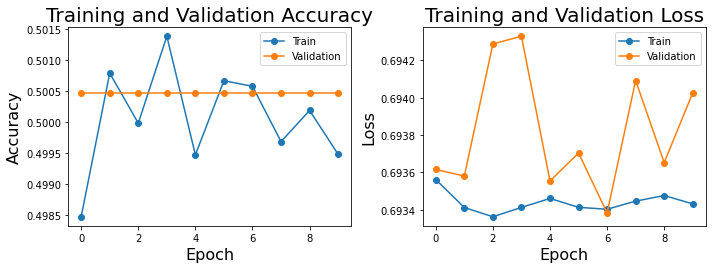

In [33]:
pcamlib.plot_history(hist_df)

In [36]:
%%time
y_proba = pcamlib.generate_y_proba(vgg16, test_pipeline, class_1=False)

KeyboardInterrupt: 

In [37]:
%%time
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 27.3 s, sys: 3.16 s, total: 30.4 s
Wall time: 6.57 s


In [45]:
%%time
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 9.38 ms, sys: 1.32 ms, total: 10.7 ms
Wall time: 10.1 ms


In [46]:
%%time
pcamlib.print_test_accuracy(y_true, y_pred)

0.500213623046875
CPU times: user 4.79 ms, sys: 3.34 ms, total: 8.13 ms
Wall time: 5.78 ms


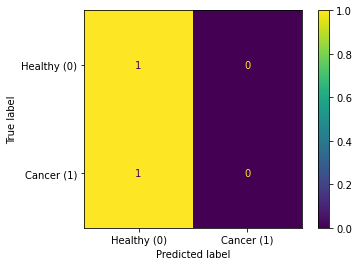

In [47]:
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True)

In [48]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.5002    1.0000    0.6669     16391
           1     0.0000    0.0000    0.0000     16377

    accuracy                         0.5002     32768
   macro avg     0.2501    0.5000    0.3334     32768
weighted avg     0.2502    0.5002    0.3336     32768



/Users/jaredlauer/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaredlauer/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaredlauer/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

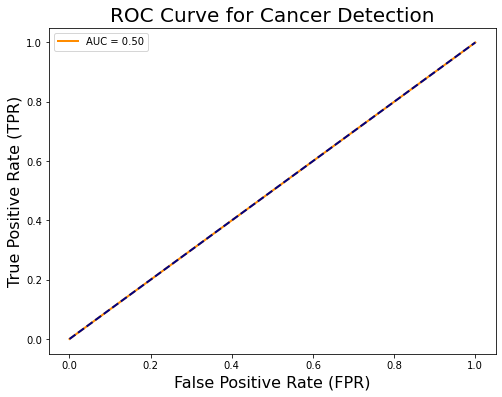

Area under curve (AUC):0.5
(2,)
(2,)


In [49]:
pcamlib.plot_roc_curve(y_true, y_proba)

1
4
5
6
8
9
10
14
17


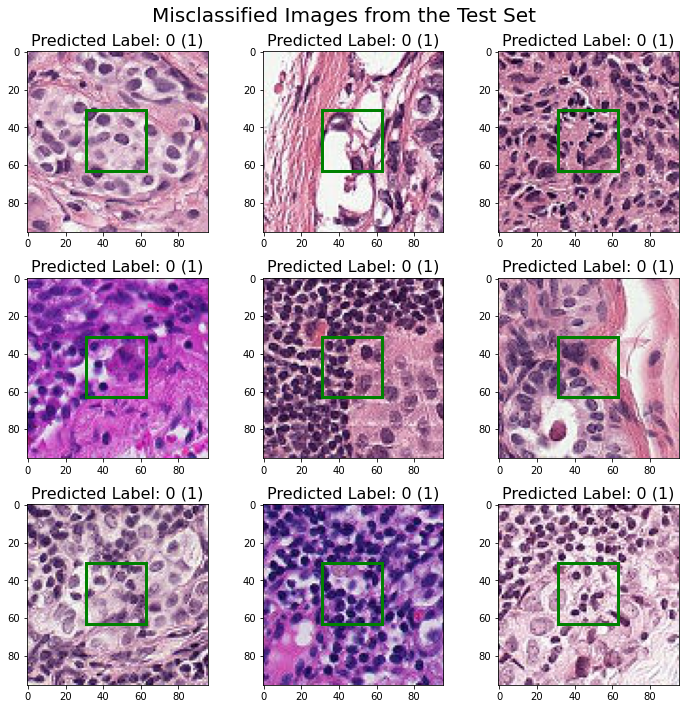

In [50]:
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)